In [1]:
from lime import lime_image
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.segmentation import mark_boundaries
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import lime
import numpy as np
import shap
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras import backend as K
from keras.models import Model
from tensorflow import keras

## Anmerkung: die Bilder werden in RGB umgewandelt, weil der LIME-Explainer bei grayscale einen Fehler liefert.

In [2]:
# Laden des MNIST Datensatzes und Aufteilen in Trainings- und Testdaten

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Umwandeln von Graustufenbildern in RGB-Bilder

train_images_rgb = gray2rgb(train_images.reshape(-1, 28, 28))
test_images_rgb = gray2rgb(test_images.reshape(-1, 28, 28))

In [3]:
# Normalisierung auf Wertebereich [0, 1]

train_images_rgb = train_images_rgb / 255.0
test_images_rgb = test_images_rgb / 255.0

# One-Hot-Encoding

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [4]:
# CNN-Modell definieren

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

In [5]:
# Zusammenfassung des Modells

model.summary()

# Namen der Convolutional-Layer

conv_layers = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]

print("Namen der Convolutional-Layer:")
print(conv_layers)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [6]:
# Modell kompilieren

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Modell trainieren

history = model.fit(train_images_rgb, train_labels, epochs=3, batch_size=64, validation_data=(
    test_images_rgb, test_labels), verbose=1)

# Bewertung des Modells auf Testdaten

test_loss, test_acc = model.evaluate(test_images_rgb, test_labels, verbose=0)
print("Test Accuracy:", test_acc)

Epoch 1/8


938/938 [==============================] - 110s 111ms/step - loss: 0.1527 - accuracy: 0.9541 - val_loss: 0.0488 - val_accuracy: 0.9842
Epoch 2/8
938/938 [==============================] - 103s 110ms/step - loss: 0.0482 - accuracy: 0.9854 - val_loss: 0.0375 - val_accuracy: 0.9881
Epoch 3/8
938/938 [==============================] - 97s 104ms/step - loss: 0.0334 - accuracy: 0.9893 - val_loss: 0.0330 - val_accuracy: 0.9893
Epoch 4/8
938/938 [==============================] - 88s 94ms/step - loss: 0.0254 - accuracy: 0.9916 - val_loss: 0.0346 - val_accuracy: 0.9900
Epoch 5/8
938/938 [==============================] - 110s 118ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.0346 - val_accuracy: 0.9882
Epoch 6/8
938/938 [==============================] - 108s 116ms/step - loss: 0.0154 - accuracy: 0.9948 - val_loss: 0.0341 - val_accuracy: 0.9890
Epoch 7/8
938/938 [==============================] - 118s 126ms/step - loss: 0.0136 - accuracy: 0.9956 - val_loss: 0.0322 - val_acc

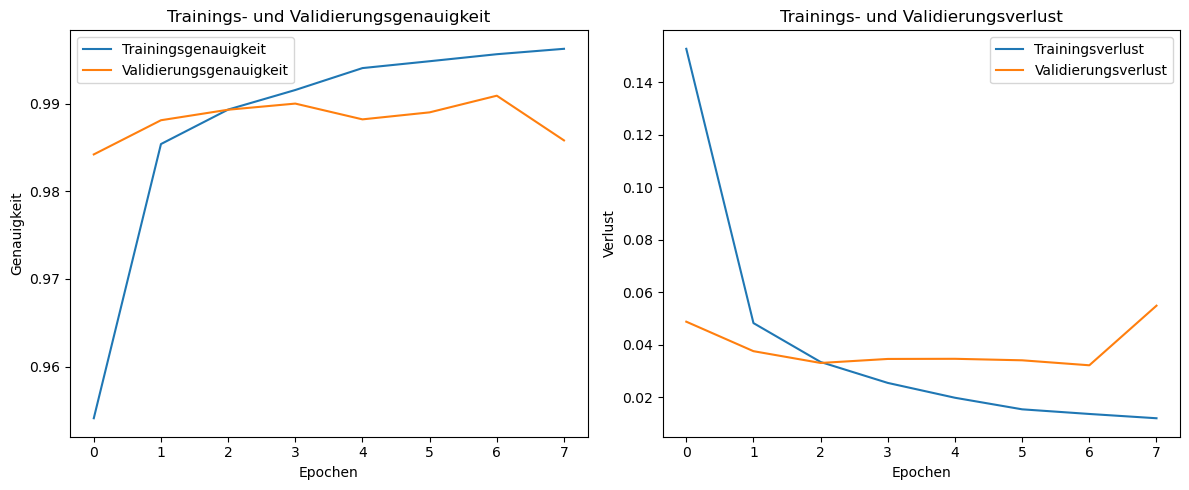

In [8]:
# Trainingshistorie visualisieren

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot für Genauigkeit

ax1.plot(history.history['accuracy'], label='Trainingsgenauigkeit')
ax1.plot(history.history['val_accuracy'], label='Validierungsgenauigkeit')
ax1.set_xlabel('Epochen')
ax1.set_ylabel('Genauigkeit')
ax1.set_title('Trainings- und Validierungsgenauigkeit')
ax1.legend()

# Plot für Verlust

ax2.plot(history.history['loss'], label='Trainingsverlust')
ax2.plot(history.history['val_loss'], label='Validierungsverlust')
ax2.set_xlabel('Epochen')
ax2.set_ylabel('Verlust')
ax2.set_title('Trainings- und Validierungsverlust')
ax2.legend()

plt.tight_layout()
plt.show()

In [9]:
# Zufällige Auswahl eines Testbildes

random_index = np.random.randint(0, len(test_images_rgb))
selected_image = test_images_rgb[random_index]
selected_label = test_labels[random_index]

In [10]:
# Vorhersage des CNN-Modells für das ausgewählte Bild

pred_probs = model.predict(np.expand_dims(selected_image, axis=0))
pred_label = np.argmax(pred_probs)

1/1 [==============================] - 0s 478ms/step


### LIME

In [11]:
# LIME auf das ausgewählte Bild anwenden

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(selected_image.astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 170ms/step


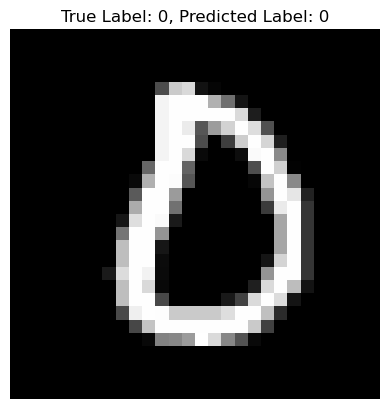

In [12]:
# Plotten des ausgewählten Bildes

plt.imshow(selected_image)
plt.axis('off')
plt.title(f"True Label: {np.argmax(selected_label)}, Predicted Label: {pred_label}")
# plt.savefig("MNIST_Figure.jpg") # Auskommentieren um das Bild als .jpg abzuspeichern
plt.show()

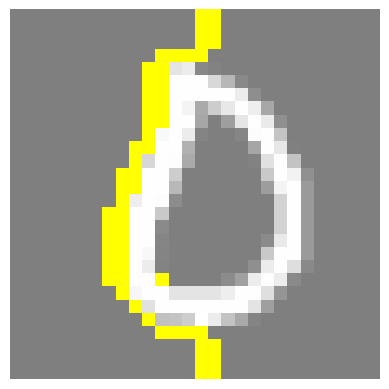

In [13]:
# Plotten der LIME-Erklärung
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
# plt.savefig("MNIST_LIME.jpg") # Bild speichern
plt.show()

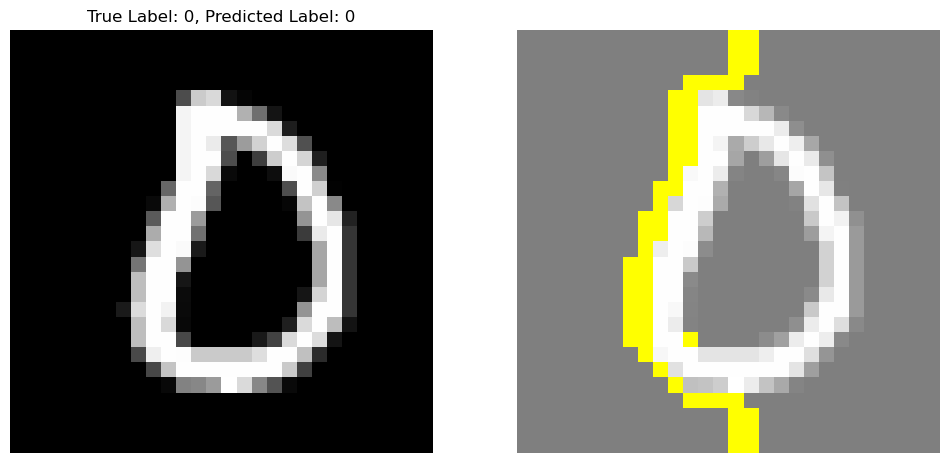

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.imshow(selected_image)
plt.axis('off')
plt.title(f"True Label: {np.argmax(selected_label)}, Predicted Label: {pred_label}")

# Plotten der LIME-Erklärung

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.savefig("MNIST_LIME_Comb.jpg")
plt.show()

### GradCAM

In [15]:
# Funktion zur Berechnung von Grad-CAM
def grad_cam(model, img_array, layer_name):
    img_tensor = np.expand_dims(img_array, axis=0)
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        heatmap_model = keras.Model([model.inputs], [last_conv_layer.output, model.output])

        conv_outputs, predictions = heatmap_model(img_tensor)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    heatmap = heatmap[0]
    heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    return heatmap

In [16]:
# Visualisierung von Grad-CAM

layer_name = 'conv2d_1'  # Name der zweiten Conv2D-Schicht

# Grad-CAM für das ausgewählte Bild

grad_cam_img = grad_cam(model, selected_image, layer_name)

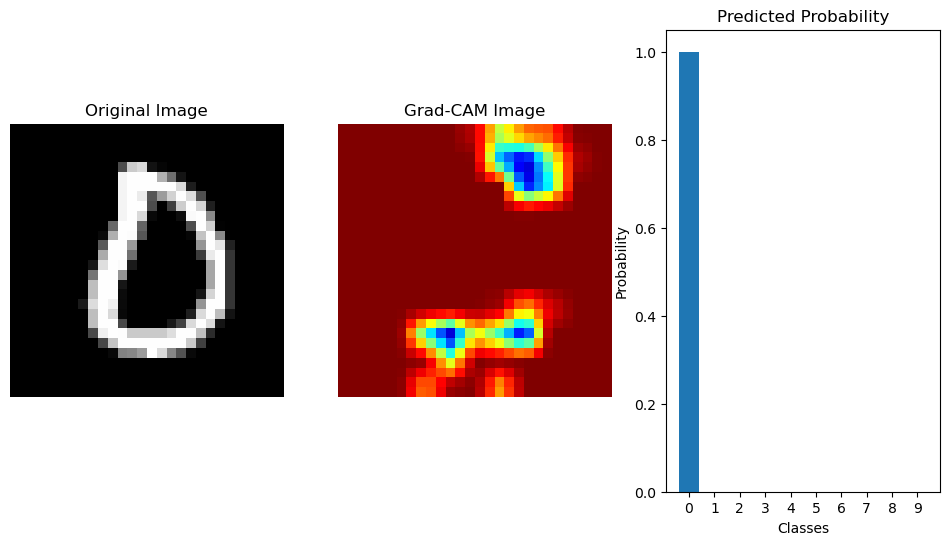

In [17]:
# Anzeigen des Originalbildes, des Grad-CAM-Bildes und des vorhergesagten Labels

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(selected_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grad_cam_img)
plt.title('Grad-CAM Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.bar(range(10), pred_probs[0])
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Predicted Probability')
plt.xticks(range(10))
plt.savefig("GradCAM_MNIST.jpg")
plt.show()